# Traditional ML Model - EDA

## Objective
Perform exploratory data analysis for supervised learning to predict household energy consumption using customer characteristics and contextual features.

## Model Definition

**Input Variables:**
- `Acorn_grouped` (Affluent, Comfortable, Adversity) 
- `stdorToU` (tariff type: ToU vs Std)
- `season` (Winter, Spring, Summer, Fall)
- `month`, `day_of_week` (temporal features)
- Weather variables (temperature, etc. if merged)

**Output Variable:**
- `energy_sum` (daily household energy consumption)

**Data Structure:** 
- Each row = one household on one day
- Preserves household-level variation (unlike time series which aggregates)

## Business Case & IoT Applications

This model addresses several **typical IoT tasks for smart meter data:**

### 1. Customer Segmentation/Clustering

**Input Variables:**
- `Acorn_grouped` (Affluent, Comfortable, Adversity)
- `season` (Winter, Spring, Summer, Fall)
- `month`, `day_of_week` (temporal features)

**Output Variable:**
- `energy_sum` (daily household energy consumption in kWh)

**Analysis & Comparison:**
- Compare mean energy consumption across ACORN socio-economic groups
- Statistical testing (ANOVA/Kruskal-Wallis) to determine if consumption differences between groups are significant
- Control for temporal factors (season, month) to isolate group-level effects

**Business Value:**
- Identify high-consumption and low-consumption customer segments
- Tailor marketing campaigns for energy efficiency programs to specific socio-economic groups
- Design targeted pricing structures that match customer affordability and consumption patterns
- Allocate resources efficiently (e.g., focus efficiency audits on high-consumption affluent areas)

---

### 2. Energy Efficiency Analysis

**Input Variables:**
- `Acorn_grouped` (household socio-economic category)
- `stdorToU` (tariff type)
- `season`, `month`, `day_of_week` (temporal controls)
- Weather variables (if available)

**Output Variable:**
- `energy_sum` (daily household energy consumption in kWh)

**Analysis & Comparison:**
- Predict expected consumption for a household given its characteristics
- Calculate residuals (actual consumption - predicted consumption) to identify outliers
- Compare households within the same ACORN group to find efficiency leaders and laggards
- Benchmark individual household performance against similar peers

**Business Value:**
- Identify inefficient households consuming significantly more than peers with similar characteristics
- Target energy efficiency interventions (audits, appliance upgrades) to households with highest savings potential
- Recognize and incentivize efficient households as case studies or program ambassadors
- Quantify potential energy savings if inefficient households were brought to group average performance

---

### 3. Demand Response

**Input Variables:**
- `stdorToU` (tariff type: Time-of-Use vs Standard)
- `season` (Winter, Spring, Summer, Fall)
- `month`, `day_of_week` (temporal patterns)
- `Acorn_grouped` (customer segment)

**Output Variable:**
- `energy_sum` (daily household energy consumption in kWh)

**Analysis & Comparison:**
- Compare consumption patterns between ToU and Standard tariff customers within same ACORN group
- Analyze seasonal variations in consumption for both tariff types
- Test if ToU customers show lower peak-season consumption due to price signals
- Identify which customer segments (ACORN groups) are most responsive to time-based pricing

**Business Value:**
- Evaluate effectiveness of demand response programs in shifting consumption
- Determine which customer segments are most likely to respond to time-of-use pricing incentives
- Forecast load reduction potential from expanding ToU programs to additional customer segments
- Design optimal pricing tiers and time windows based on observed behavioral responses
- Reduce need for expensive peak generation capacity by flattening demand curves

---

### 4. Tariff Optimization

**Input Variables:**
- `stdorToU` (current tariff type)
- `Acorn_grouped` (socio-economic category)
- `energy_sum` (historical consumption)
- `season`, `month`, `day_of_week` (temporal factors)

**Output Variable:**
- `energy_sum` (predicted daily consumption in kWh)
- Cost implications under different tariff structures (derived metric)

**Analysis & Comparison:**
- Model consumption under both Standard and ToU tariffs for each household
- Calculate total cost for each household under both tariff structures
- Compare actual tariff assignment vs. optimal tariff for minimizing customer cost or maximizing utility revenue
- Segment households by tariff suitability based on consumption patterns

**Business Value:**
- Recommend optimal tariff for each customer to reduce their energy bills (improve customer satisfaction)
- Identify customers on Standard tariffs who would save money on ToU plans (targeted marketing)
- Identify customers on ToU tariffs who are not benefiting (prevent churn, offer alternatives)
- Balance utility revenue objectives with customer cost savings
- Design new tariff structures based on consumption pattern clusters

---

**Model Type**: Supervised learning for customer behavior prediction - using household characteristics to predict energy usage patterns for targeted utility programs and pricing strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Data Loading and Preparation

Load the daily dataset and merge with household information to create the feature-rich dataset.

In [4]:
# Load the daily dataset
df = pd.read_csv('../build/datasets/daily_dataset.csv')

# Convert day to datetime
df['day'] = pd.to_datetime(df['day'])

# Load household information
household_info = pd.read_csv('../build/datasets/informations_households.csv')

# Merge with household information
ml_data = df.merge(household_info, on='LCLid', how='left')

# Clean ACORN groups (remove ambiguous categories)
ml_data = ml_data[~ml_data['Acorn_grouped'].isin(['ACORN-U', 'ACORN-'])]

# Drop rows with missing target or key features
ml_data = ml_data.dropna(subset=['energy_sum', 'Acorn_grouped', 'stdorToU'])

print(f"ML dataset shape: {ml_data.shape}")
print(f"Date range: {ml_data['day'].min()} to {ml_data['day'].max()}")
print(f"Unique households: {ml_data['LCLid'].nunique()}")

ml_data.head()

ML dataset shape: (3480070, 13)
Date range: 2011-11-23 00:00:00 to 2014-02-28 00:00:00
Unique households: 5510


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,Std,ACORN-E,Affluent,block_22
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,Std,ACORN-E,Affluent,block_22
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,Std,ACORN-E,Affluent,block_22
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,Std,ACORN-E,Affluent,block_22
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,Std,ACORN-E,Affluent,block_22


## Feature Engineering

Create temporal and categorical features for the model.

In [6]:
# Create temporal features
ml_data['year'] = ml_data['day'].dt.year
ml_data['month'] = ml_data['day'].dt.month
ml_data['day_of_week'] = ml_data['day'].dt.dayofweek
ml_data['day_of_year'] = ml_data['day'].dt.dayofyear
ml_data['is_weekend'] = (ml_data['day'].dt.dayofweek >= 5).astype(int)

# Create season feature
ml_data['season'] = ml_data['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Define feature columns
categorical_features = ['Acorn_grouped', 'stdorToU', 'season']
numerical_features = ['month', 'day_of_week', 'day_of_year', 'is_weekend', 'year']
target_variable = 'energy_sum'

print("=== Feature Summary ===")
print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"Target variable: {target_variable}")

# Check feature distributions
print("\n=== Categorical Feature Distributions ===")
for feature in categorical_features:
    print(f"\n{feature}:")
    print(ml_data[feature].value_counts())

=== Feature Summary ===
Categorical features: ['Acorn_grouped', 'stdorToU', 'season']
Numerical features: ['month', 'day_of_week', 'day_of_year', 'is_weekend', 'year']
Target variable: energy_sum

=== Categorical Feature Distributions ===

Acorn_grouped:
Acorn_grouped
Affluent       1407678
Adversity      1135331
Comfortable     937061
Name: count, dtype: int64

stdorToU:
stdorToU
Std    2780747
ToU     699323
Name: count, dtype: int64

season:
season
Winter    986545
Fall      940867
Summer    891199
Spring    661459
Name: count, dtype: int64


## Target Variable Analysis

Analyze the distribution and characteristics of daily energy consumption.

=== Target Variable Statistics ===
Mean: 10.111 kWh/day
Median: 7.817 kWh/day
Std: 9.086 kWh/day
Min: 0.000 kWh/day
Max: 332.556 kWh/day
Skewness: 3.846
Kurtosis: 33.627


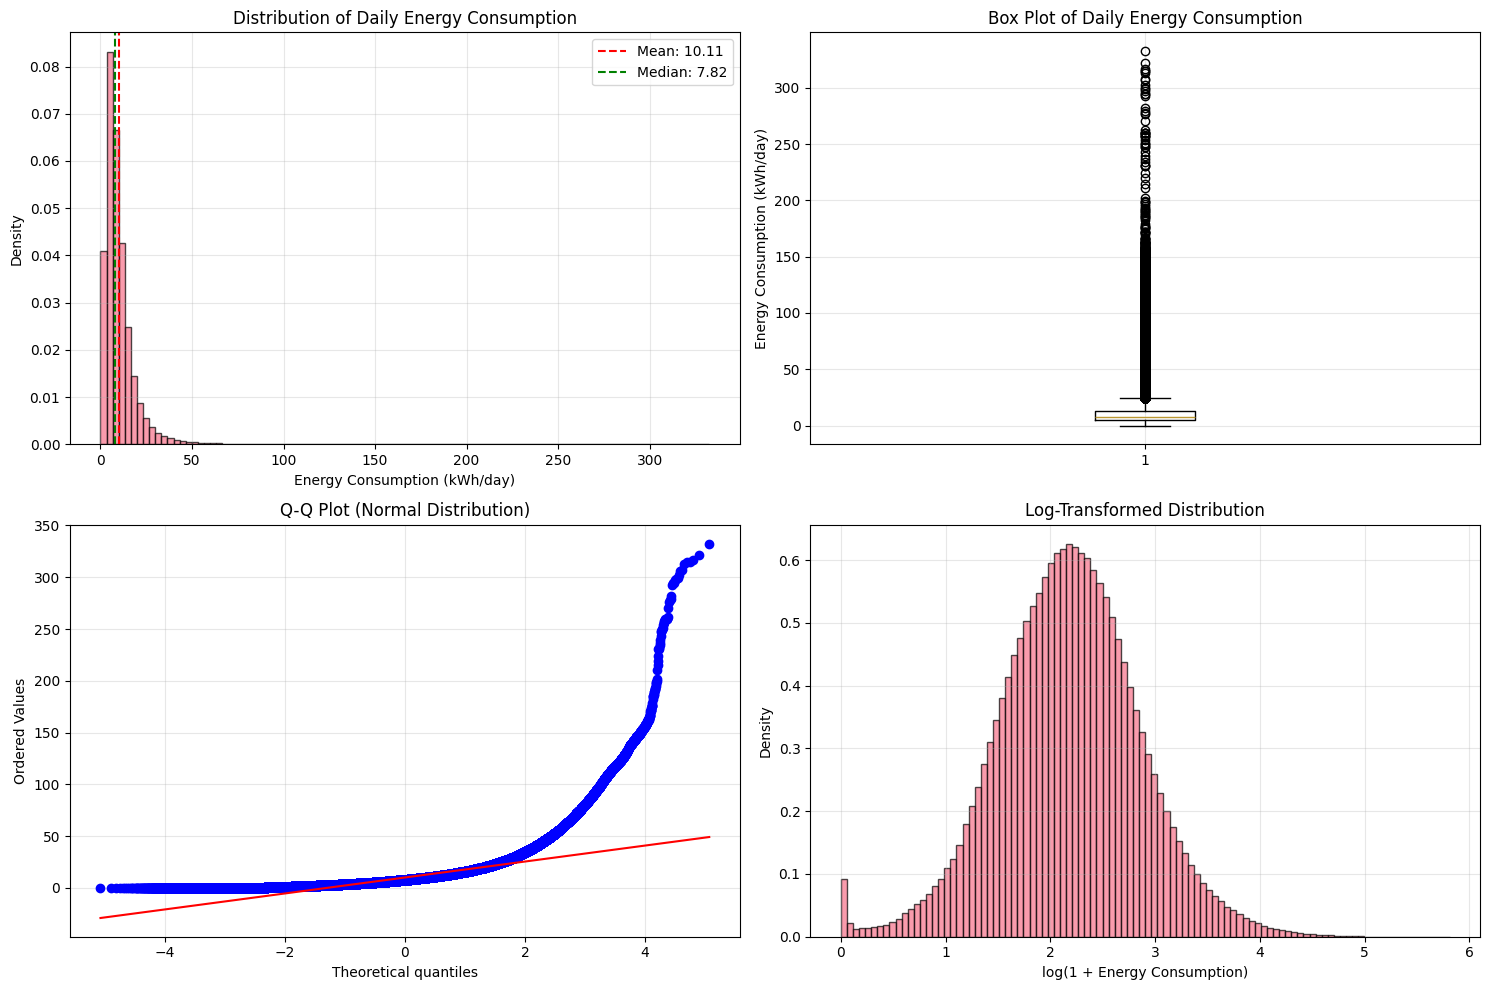


=== Outlier Analysis ===
Outliers detected: 198959 (5.7% of data)
Outlier threshold: < -7.11 or > 24.35 kWh/day


In [7]:
# Target variable statistics
target = ml_data[target_variable]

print("=== Target Variable Statistics ===")
print(f"Mean: {target.mean():.3f} kWh/day")
print(f"Median: {target.median():.3f} kWh/day")
print(f"Std: {target.std():.3f} kWh/day")
print(f"Min: {target.min():.3f} kWh/day")
print(f"Max: {target.max():.3f} kWh/day")
print(f"Skewness: {stats.skew(target):.3f}")
print(f"Kurtosis: {stats.kurtosis(target):.3f}")

# Plot target distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0,0].hist(target, bins=100, density=True, alpha=0.7, edgecolor='black')
axes[0,0].axvline(target.mean(), color='red', linestyle='--', label=f'Mean: {target.mean():.2f}')
axes[0,0].axvline(target.median(), color='green', linestyle='--', label=f'Median: {target.median():.2f}')
axes[0,0].set_title('Distribution of Daily Energy Consumption')
axes[0,0].set_xlabel('Energy Consumption (kWh/day)')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Box plot
axes[0,1].boxplot(target)
axes[0,1].set_title('Box Plot of Daily Energy Consumption')
axes[0,1].set_ylabel('Energy Consumption (kWh/day)')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(target, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normal Distribution)')
axes[1,0].grid(True, alpha=0.3)

# Log-transformed distribution
log_target = np.log1p(target)  # log(1+x) to handle zeros
axes[1,1].hist(log_target, bins=100, density=True, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Log-Transformed Distribution')
axes[1,1].set_xlabel('log(1 + Energy Consumption)')
axes[1,1].set_ylabel('Density')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Outlier analysis
Q1 = target.quantile(0.25)
Q3 = target.quantile(0.75)
IQR = Q3 - Q1
outliers = target[(target < Q1 - 1.5*IQR) | (target > Q3 + 1.5*IQR)]
print(f"\n=== Outlier Analysis ===")
print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(target):.1%} of data)")
print(f"Outlier threshold: < {Q1 - 1.5*IQR:.2f} or > {Q3 + 1.5*IQR:.2f} kWh/day")

## Feature-Target Relationships

Analyze how each feature relates to energy consumption to understand predictive power.

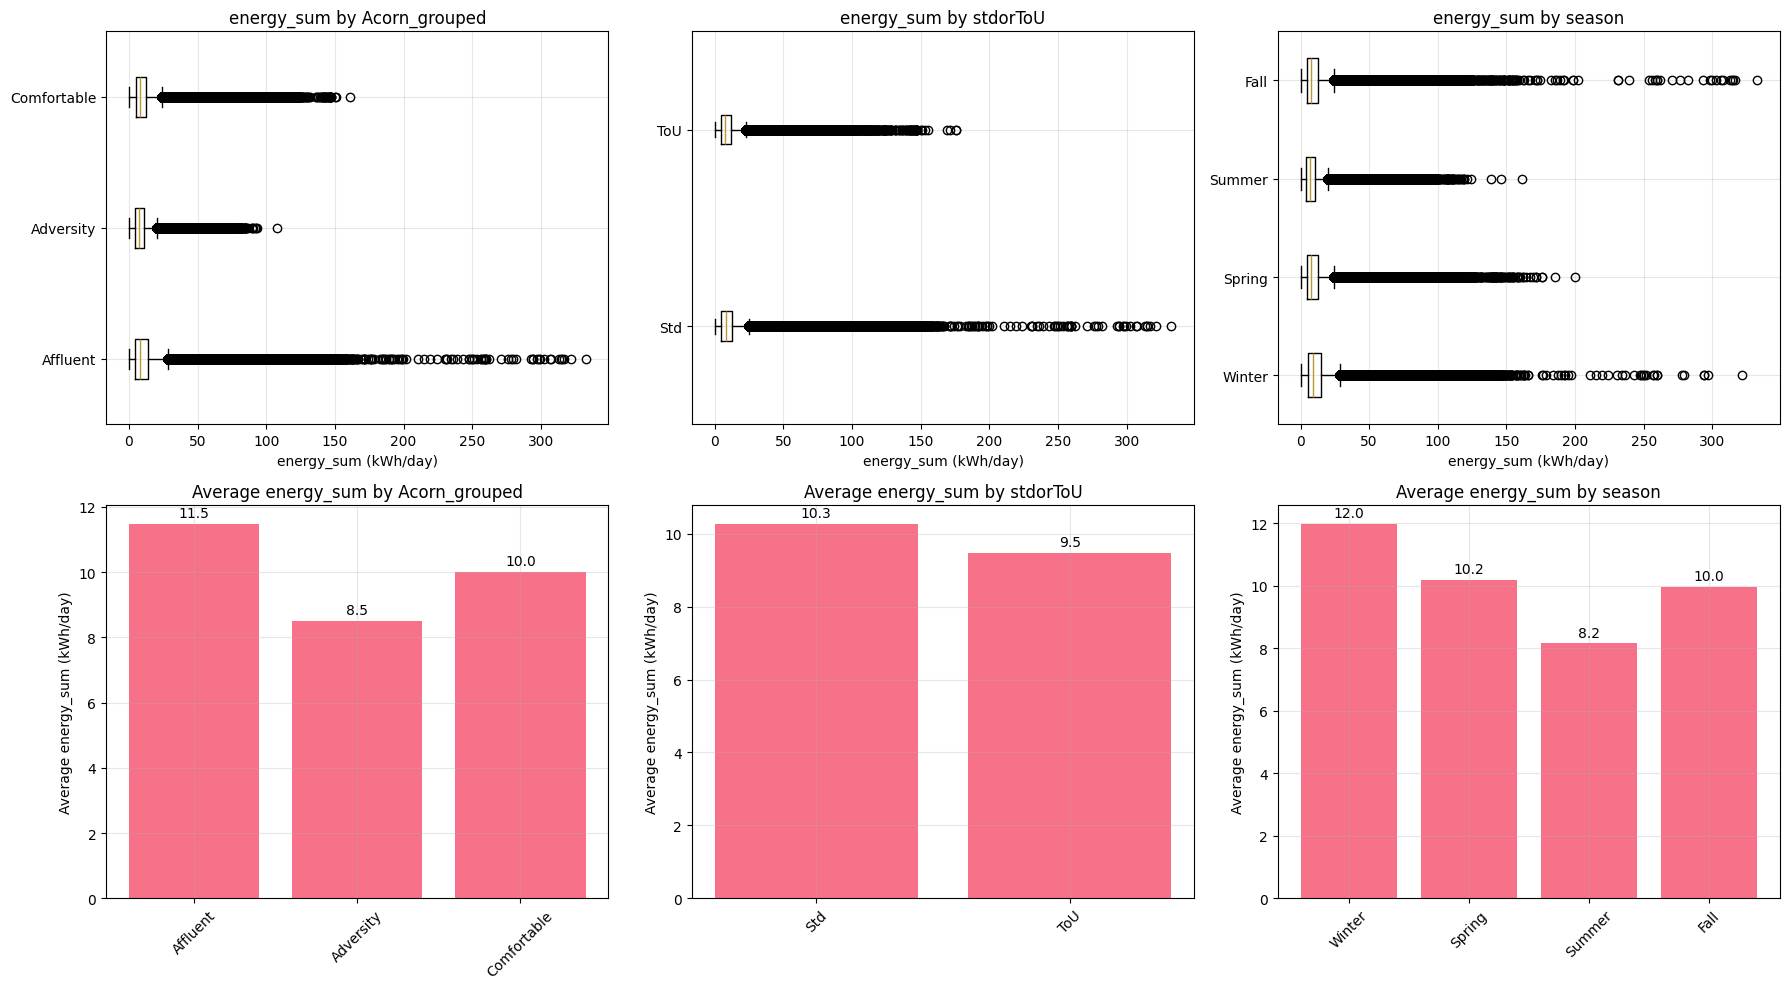

In [8]:
# Helper function for creating grouped analysis plots
def create_groups(dataset, variable, group_key, group_values):
    """Create groups of data for analysis"""
    data_by_group = [dataset[dataset[group_key] == value][variable].dropna() for value in group_values]
    return data_by_group

def plot_categorical_analysis(df, target_var, cat_features):
    """Plot categorical feature analysis"""
    n_features = len(cat_features)
    fig, axes = plt.subplots(2, n_features, figsize=(6*n_features, 10))
    
    if n_features == 1:
        axes = axes.reshape(2, 1)
    
    for i, feature in enumerate(cat_features):
        # Box plots
        feature_values = df[feature].unique()
        data_by_group = create_groups(df, target_var, feature, feature_values)
        
        axes[0,i].boxplot(data_by_group, labels=feature_values, vert=False)
        axes[0,i].set_title(f'{target_var} by {feature}')
        axes[0,i].set_xlabel(f'{target_var} (kWh/day)')
        axes[0,i].grid(True, alpha=0.3)
        
        # Mean comparison
        means = [group.mean() for group in data_by_group]
        axes[1,i].bar(feature_values, means)
        axes[1,i].set_title(f'Average {target_var} by {feature}')
        axes[1,i].set_ylabel(f'Average {target_var} (kWh/day)')
        axes[1,i].tick_params(axis='x', rotation=45)
        axes[1,i].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(means):
            axes[1,i].text(j, v + max(means)*0.01, f'{v:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Analyze categorical features
plot_categorical_analysis(ml_data, target_variable, categorical_features)

In [9]:
# Statistical significance tests for categorical features
from scipy.stats import f_oneway, kruskal

print("=== Statistical Significance Tests ===")
print("Testing if groups have significantly different energy consumption\n")

for feature in categorical_features:
    print(f"--- {feature} ---")
    
    # Get groups
    groups = []
    group_names = []
    for value in ml_data[feature].unique():
        group_data = ml_data[ml_data[feature] == value][target_variable].dropna()
        if len(group_data) > 0:
            groups.append(group_data)
            group_names.append(value)
    
    if len(groups) >= 2:
        # ANOVA test (assumes normality)
        f_stat, f_p = f_oneway(*groups)
        print(f"ANOVA F-test: F={f_stat:.3f}, p-value={f_p:.6f}")
        
        # Kruskal-Wallis test (non-parametric)
        h_stat, h_p = kruskal(*groups)
        print(f"Kruskal-Wallis test: H={h_stat:.3f}, p-value={h_p:.6f}")
        
        # Group statistics
        print("Group means:")
        for i, name in enumerate(group_names):
            print(f"  {name}: {groups[i].mean():.2f} ± {groups[i].std():.2f} kWh/day (n={len(groups[i])})")
        
        if f_p < 0.05:
            print("Result: Groups have significantly different means (p < 0.05)")
        else:
            print("Result: No significant difference between groups (p >= 0.05)")
    
    print()

=== Statistical Significance Tests ===
Testing if groups have significantly different energy consumption

--- Acorn_grouped ---
ANOVA F-test: F=34450.576, p-value=0.000000
Kruskal-Wallis test: H=41337.999, p-value=0.000000
Group means:
  Affluent: 11.48 ± 11.27 kWh/day (n=1407678)
  Adversity: 8.50 ± 6.30 kWh/day (n=1135331)
  Comfortable: 10.00 ± 7.85 kWh/day (n=937061)
Result: Groups have significantly different means (p < 0.05)

--- stdorToU ---
ANOVA F-test: F=4167.608, p-value=0.000000
Kruskal-Wallis test: H=3148.731, p-value=0.000000
Group means:
  Std: 10.27 ± 9.32 kWh/day (n=2780747)
  ToU: 9.48 ± 8.07 kWh/day (n=699323)
Result: Groups have significantly different means (p < 0.05)

--- season ---
ANOVA F-test: F=28342.037, p-value=0.000000
Kruskal-Wallis test: H=76753.545, p-value=0.000000
Group means:
  Winter: 11.97 ± 11.06 kWh/day (n=986545)
  Spring: 10.18 ± 9.13 kWh/day (n=661459)
  Summer: 8.16 ± 6.28 kWh/day (n=891199)
  Fall: 9.96 ± 8.60 kWh/day (n=940867)
Result: Group

## Temporal Feature Analysis

Analyze how temporal features relate to energy consumption.

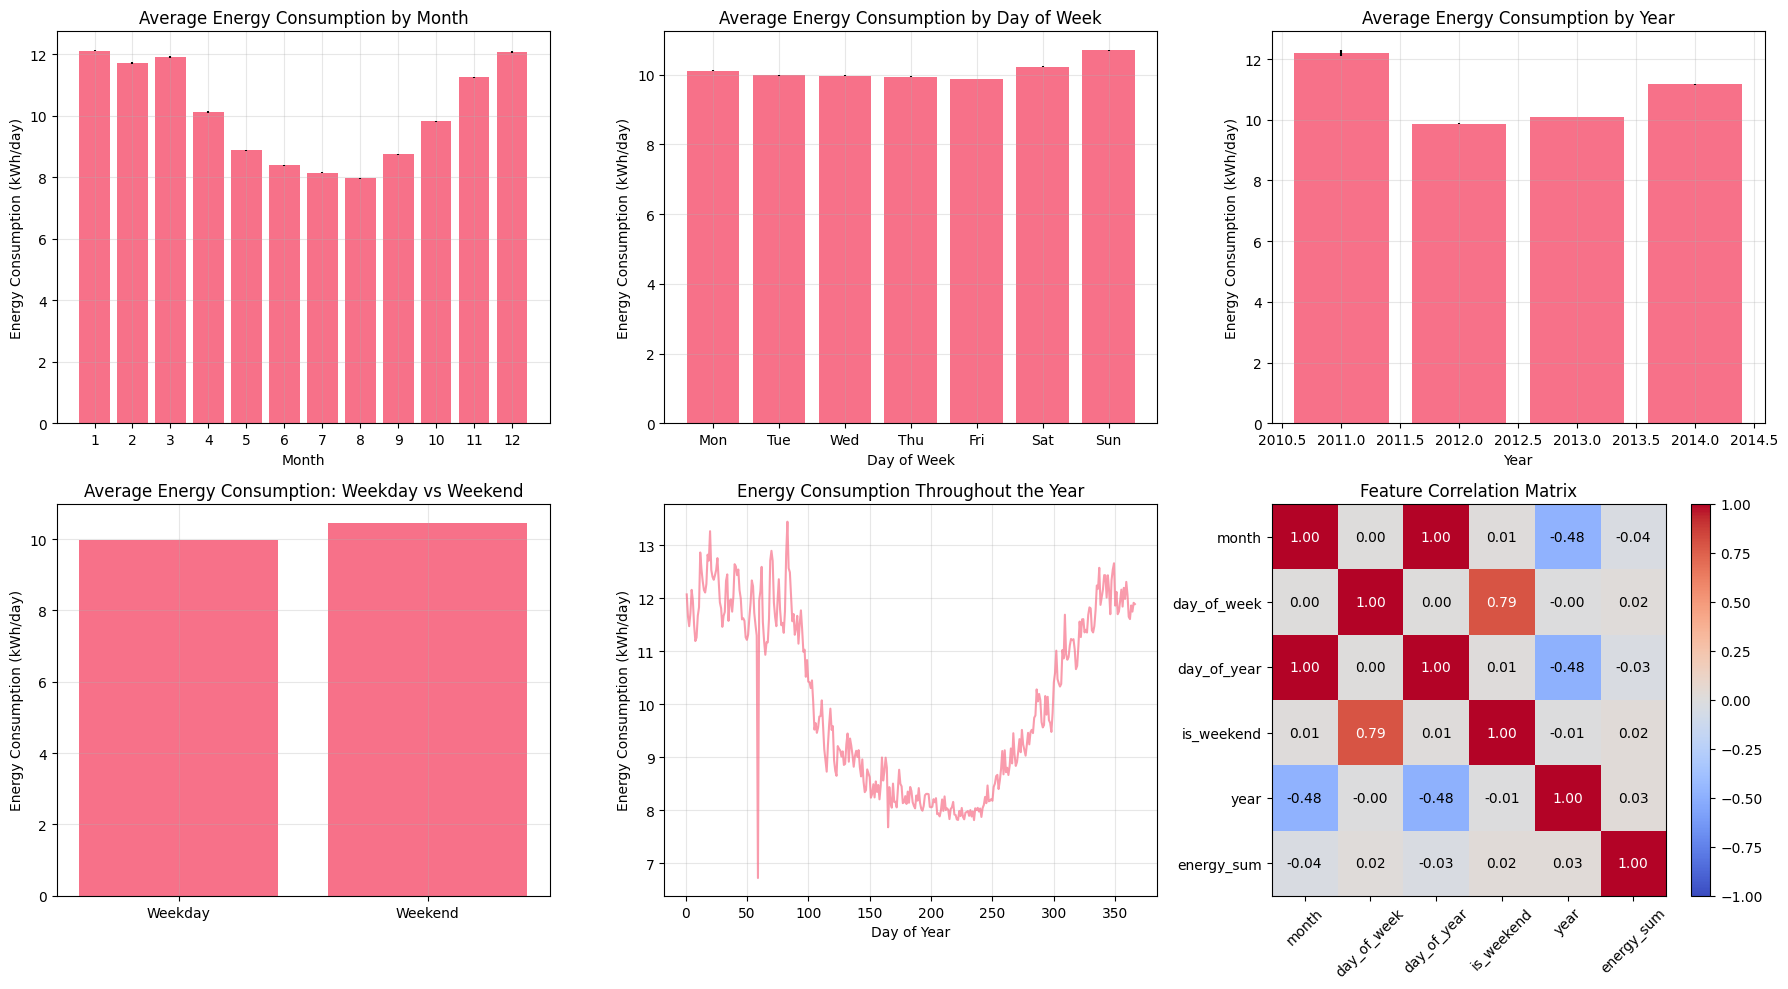

=== Temporal Pattern Insights ===
Highest consumption month: 1 (12.12 kWh/day)
Lowest consumption month: 8 (7.96 kWh/day)
Weekend vs Weekday difference: 0.48 kWh/day
Year-over-year change: -1.02 kWh/day


In [10]:
# Temporal feature analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Monthly patterns
monthly_avg = ml_data.groupby('month')[target_variable].agg(['mean', 'std', 'count'])
axes[0,0].bar(monthly_avg.index, monthly_avg['mean'], yerr=monthly_avg['std']/np.sqrt(monthly_avg['count']))
axes[0,0].set_title('Average Energy Consumption by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Energy Consumption (kWh/day)')
axes[0,0].set_xticks(range(1, 13))
axes[0,0].grid(True, alpha=0.3)

# Day of week patterns
dow_avg = ml_data.groupby('day_of_week')[target_variable].agg(['mean', 'std', 'count'])
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(dow_avg.index, dow_avg['mean'], yerr=dow_avg['std']/np.sqrt(dow_avg['count']))
axes[0,1].set_title('Average Energy Consumption by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Energy Consumption (kWh/day)')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(dow_names)
axes[0,1].grid(True, alpha=0.3)

# Yearly trends
yearly_avg = ml_data.groupby('year')[target_variable].agg(['mean', 'std', 'count'])
axes[0,2].bar(yearly_avg.index, yearly_avg['mean'], yerr=yearly_avg['std']/np.sqrt(yearly_avg['count']))
axes[0,2].set_title('Average Energy Consumption by Year')
axes[0,2].set_xlabel('Year')
axes[0,2].set_ylabel('Energy Consumption (kWh/day)')
axes[0,2].grid(True, alpha=0.3)

# Weekend vs weekday
weekend_avg = ml_data.groupby('is_weekend')[target_variable].agg(['mean', 'std', 'count'])
weekend_labels = ['Weekday', 'Weekend']
axes[1,0].bar(weekend_avg.index, weekend_avg['mean'], yerr=weekend_avg['std']/np.sqrt(weekend_avg['count']))
axes[1,0].set_title('Average Energy Consumption: Weekday vs Weekend')
axes[1,0].set_ylabel('Energy Consumption (kWh/day)')
axes[1,0].set_xticks([0, 1])
axes[1,0].set_xticklabels(weekend_labels)
axes[1,0].grid(True, alpha=0.3)

# Day of year (seasonal pattern)
doy_avg = ml_data.groupby('day_of_year')[target_variable].mean()
axes[1,1].plot(doy_avg.index, doy_avg.values, alpha=0.7)
axes[1,1].set_title('Energy Consumption Throughout the Year')
axes[1,1].set_xlabel('Day of Year')
axes[1,1].set_ylabel('Energy Consumption (kWh/day)')
axes[1,1].grid(True, alpha=0.3)

# Correlation heatmap for numerical features
corr_features = numerical_features + [target_variable]
correlation_matrix = ml_data[corr_features].corr()
im = axes[1,2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,2].set_title('Feature Correlation Matrix')
axes[1,2].set_xticks(range(len(corr_features)))
axes[1,2].set_yticks(range(len(corr_features)))
axes[1,2].set_xticklabels(corr_features, rotation=45)
axes[1,2].set_yticklabels(corr_features)

# Add correlation values to heatmap
for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        axes[1,2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                      ha='center', va='center', color='white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=axes[1,2])
plt.tight_layout()
plt.show()

# Print temporal insights
print("=== Temporal Pattern Insights ===")
print(f"Highest consumption month: {monthly_avg['mean'].idxmax()} ({monthly_avg['mean'].max():.2f} kWh/day)")
print(f"Lowest consumption month: {monthly_avg['mean'].idxmin()} ({monthly_avg['mean'].min():.2f} kWh/day)")
print(f"Weekend vs Weekday difference: {weekend_avg['mean'][1] - weekend_avg['mean'][0]:.2f} kWh/day")
print(f"Year-over-year change: {yearly_avg['mean'].iloc[-1] - yearly_avg['mean'].iloc[0]:.2f} kWh/day")

## Feature Interaction Analysis

Analyze how features interact with each other to affect energy consumption.

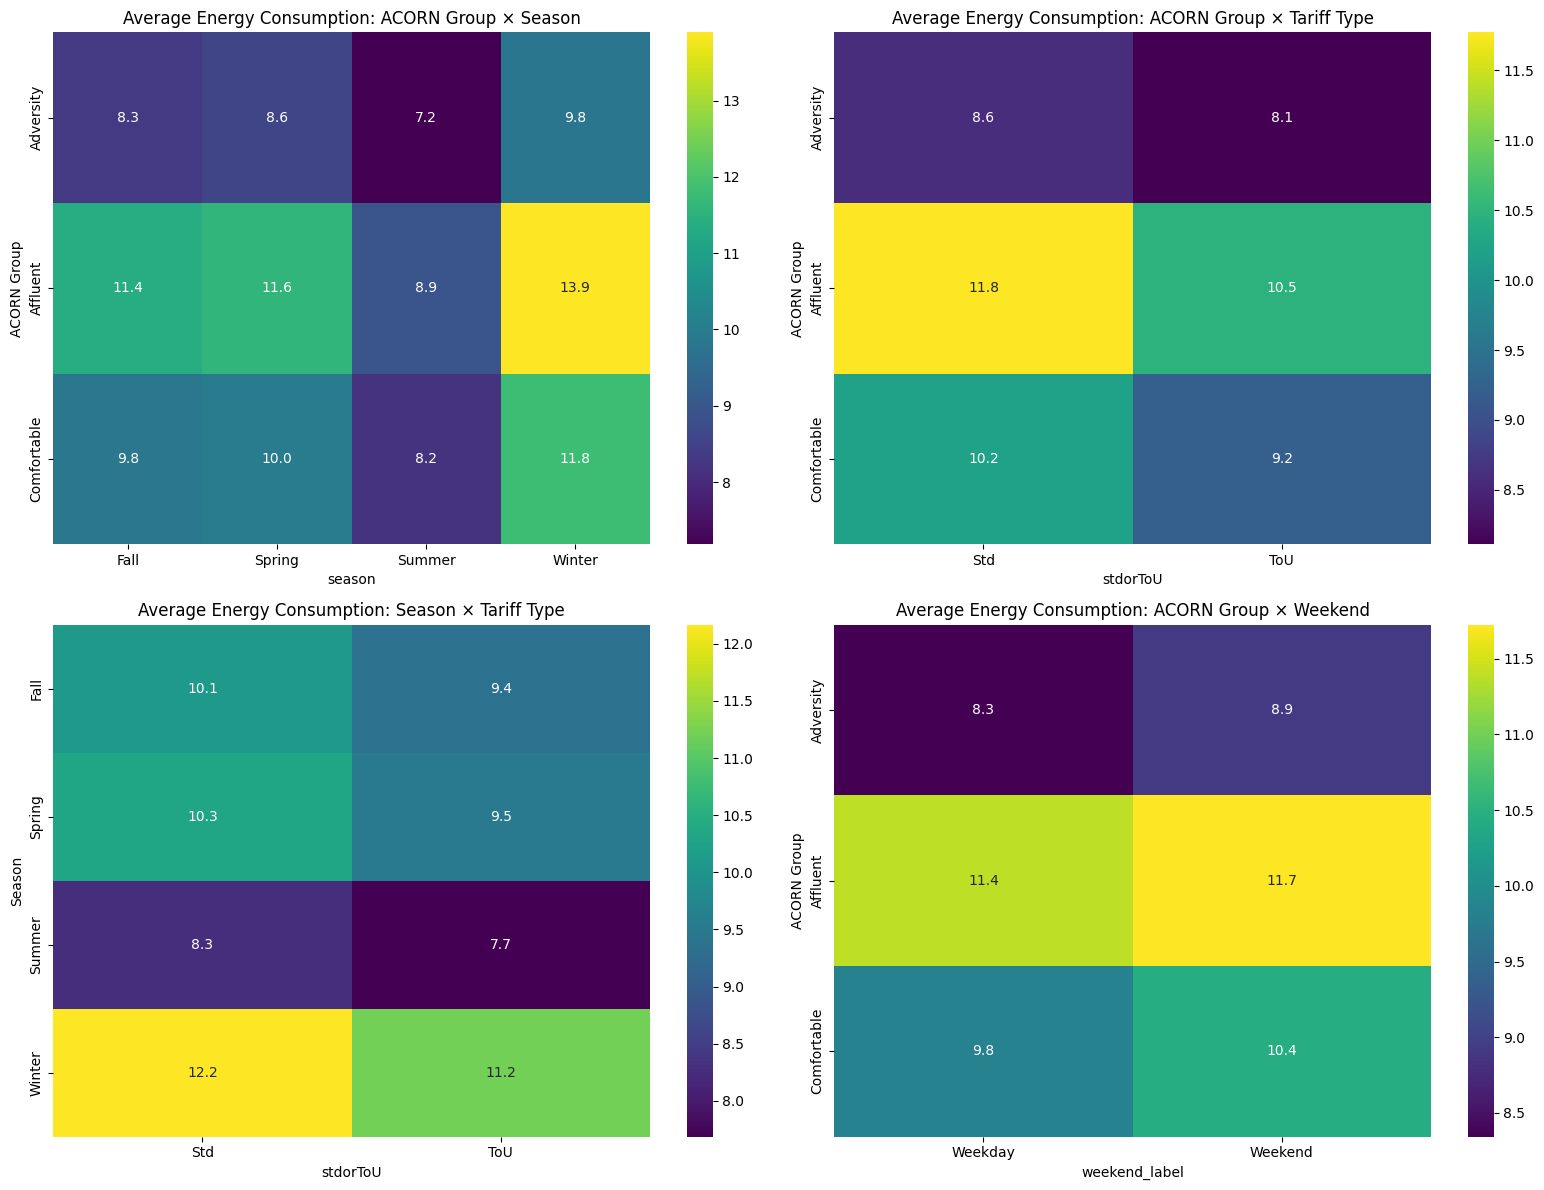

=== Feature Interaction Insights ===

ACORN Group × Season:
  Adversity: 2.6 kWh/day seasonal variation
  Affluent: 5.0 kWh/day seasonal variation
  Comfortable: 3.6 kWh/day seasonal variation

ACORN Group × Tariff Type:
  Adversity: 0.5 kWh/day difference (Std - ToU)
  Affluent: 1.3 kWh/day difference (Std - ToU)
  Comfortable: 1.0 kWh/day difference (Std - ToU)

Season × Tariff Type:
  Fall: 0.8 kWh/day difference (Std - ToU)
  Spring: 0.8 kWh/day difference (Std - ToU)
  Summer: 0.6 kWh/day difference (Std - ToU)
  Winter: 1.0 kWh/day difference (Std - ToU)


In [11]:
# Feature interaction analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ACORN group by Season
pivot_acorn_season = ml_data.pivot_table(values=target_variable, index='Acorn_grouped', columns='season', aggfunc='mean')
sns.heatmap(pivot_acorn_season, annot=True, fmt='.1f', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Average Energy Consumption: ACORN Group × Season')
axes[0,0].set_ylabel('ACORN Group')

# ACORN group by Tariff type
pivot_acorn_tariff = ml_data.pivot_table(values=target_variable, index='Acorn_grouped', columns='stdorToU', aggfunc='mean')
sns.heatmap(pivot_acorn_tariff, annot=True, fmt='.1f', cmap='viridis', ax=axes[0,1])
axes[0,1].set_title('Average Energy Consumption: ACORN Group × Tariff Type')
axes[0,1].set_ylabel('ACORN Group')

# Season by Tariff type
pivot_season_tariff = ml_data.pivot_table(values=target_variable, index='season', columns='stdorToU', aggfunc='mean')
sns.heatmap(pivot_season_tariff, annot=True, fmt='.1f', cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Average Energy Consumption: Season × Tariff Type')
axes[1,0].set_ylabel('Season')

# ACORN group by Weekend
ml_data['weekend_label'] = ml_data['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
pivot_acorn_weekend = ml_data.pivot_table(values=target_variable, index='Acorn_grouped', columns='weekend_label', aggfunc='mean')
sns.heatmap(pivot_acorn_weekend, annot=True, fmt='.1f', cmap='viridis', ax=axes[1,1])
axes[1,1].set_title('Average Energy Consumption: ACORN Group × Weekend')
axes[1,1].set_ylabel('ACORN Group')

plt.tight_layout()
plt.show()

# Statistical interaction analysis
print("=== Feature Interaction Insights ===")
print()

# ACORN × Season interaction
print("ACORN Group × Season:")
for acorn in pivot_acorn_season.index:
    seasonal_range = pivot_acorn_season.loc[acorn].max() - pivot_acorn_season.loc[acorn].min()
    print(f"  {acorn}: {seasonal_range:.1f} kWh/day seasonal variation")

print("\nACORN Group × Tariff Type:")
for acorn in pivot_acorn_tariff.index:
    if 'Std' in pivot_acorn_tariff.columns and 'ToU' in pivot_acorn_tariff.columns:
        tariff_diff = pivot_acorn_tariff.loc[acorn, 'Std'] - pivot_acorn_tariff.loc[acorn, 'ToU']
        print(f"  {acorn}: {tariff_diff:.1f} kWh/day difference (Std - ToU)")

print("\nSeason × Tariff Type:")
for season in pivot_season_tariff.index:
    if 'Std' in pivot_season_tariff.columns and 'ToU' in pivot_season_tariff.columns:
        tariff_diff = pivot_season_tariff.loc[season, 'Std'] - pivot_season_tariff.loc[season, 'ToU']
        print(f"  {season}: {tariff_diff:.1f} kWh/day difference (Std - ToU)")

## Data Preparation for Modeling

Prepare the dataset for machine learning by encoding categorical variables and splitting the data.

In [12]:
# Prepare modeling dataset
modeling_data = ml_data.copy()

# Remove rows with missing values in key features
feature_columns = categorical_features + numerical_features
modeling_data = modeling_data.dropna(subset=feature_columns + [target_variable])

# Encode categorical variables
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    modeling_data[f'{feature}_encoded'] = le.fit_transform(modeling_data[feature])
    label_encoders[feature] = le
    print(f"{feature} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Create final feature matrix
encoded_categorical = [f'{feature}_encoded' for feature in categorical_features]
final_features = encoded_categorical + numerical_features

X = modeling_data[final_features]
y = modeling_data[target_variable]

print(f"\n=== Modeling Dataset Summary ===")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {final_features}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=modeling_data['Acorn_grouped']
)

print(f"\n=== Data Split ===")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test set proportion: {X_test.shape[0] / X.shape[0]:.1%}")

# Feature scaling (for algorithms that require it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling completed.")
print(f"Scaled features - Mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Scaled features - Std: {X_train_scaled.std(axis=0).round(3)}")

Acorn_grouped encoding: {'Adversity': np.int64(0), 'Affluent': np.int64(1), 'Comfortable': np.int64(2)}
stdorToU encoding: {'Std': np.int64(0), 'ToU': np.int64(1)}
season encoding: {'Fall': np.int64(0), 'Spring': np.int64(1), 'Summer': np.int64(2), 'Winter': np.int64(3)}

=== Modeling Dataset Summary ===
Feature matrix shape: (3480070, 8)
Target vector shape: (3480070,)
Features: ['Acorn_grouped_encoded', 'stdorToU_encoded', 'season_encoded', 'month', 'day_of_week', 'day_of_year', 'is_weekend', 'year']

=== Data Split ===
Training set: 2784056 samples
Test set: 696014 samples
Test set proportion: 20.0%

Feature scaling completed.
Scaled features - Mean: [ 0.  0.  0.  0.  0.  0. -0.  0.]
Scaled features - Std: [1. 1. 1. 1. 1. 1. 1. 1.]


## Baseline Model Comparison

Train and compare baseline models to establish performance benchmarks.

=== Baseline Model Performance ===

Linear Regression:
  RMSE: 9.033 kWh/day
  MAE:  5.822 kWh/day
  R²:   0.010

Random Forest:
  RMSE: 8.798 kWh/day
  MAE:  5.699 kWh/day
  R²:   0.061



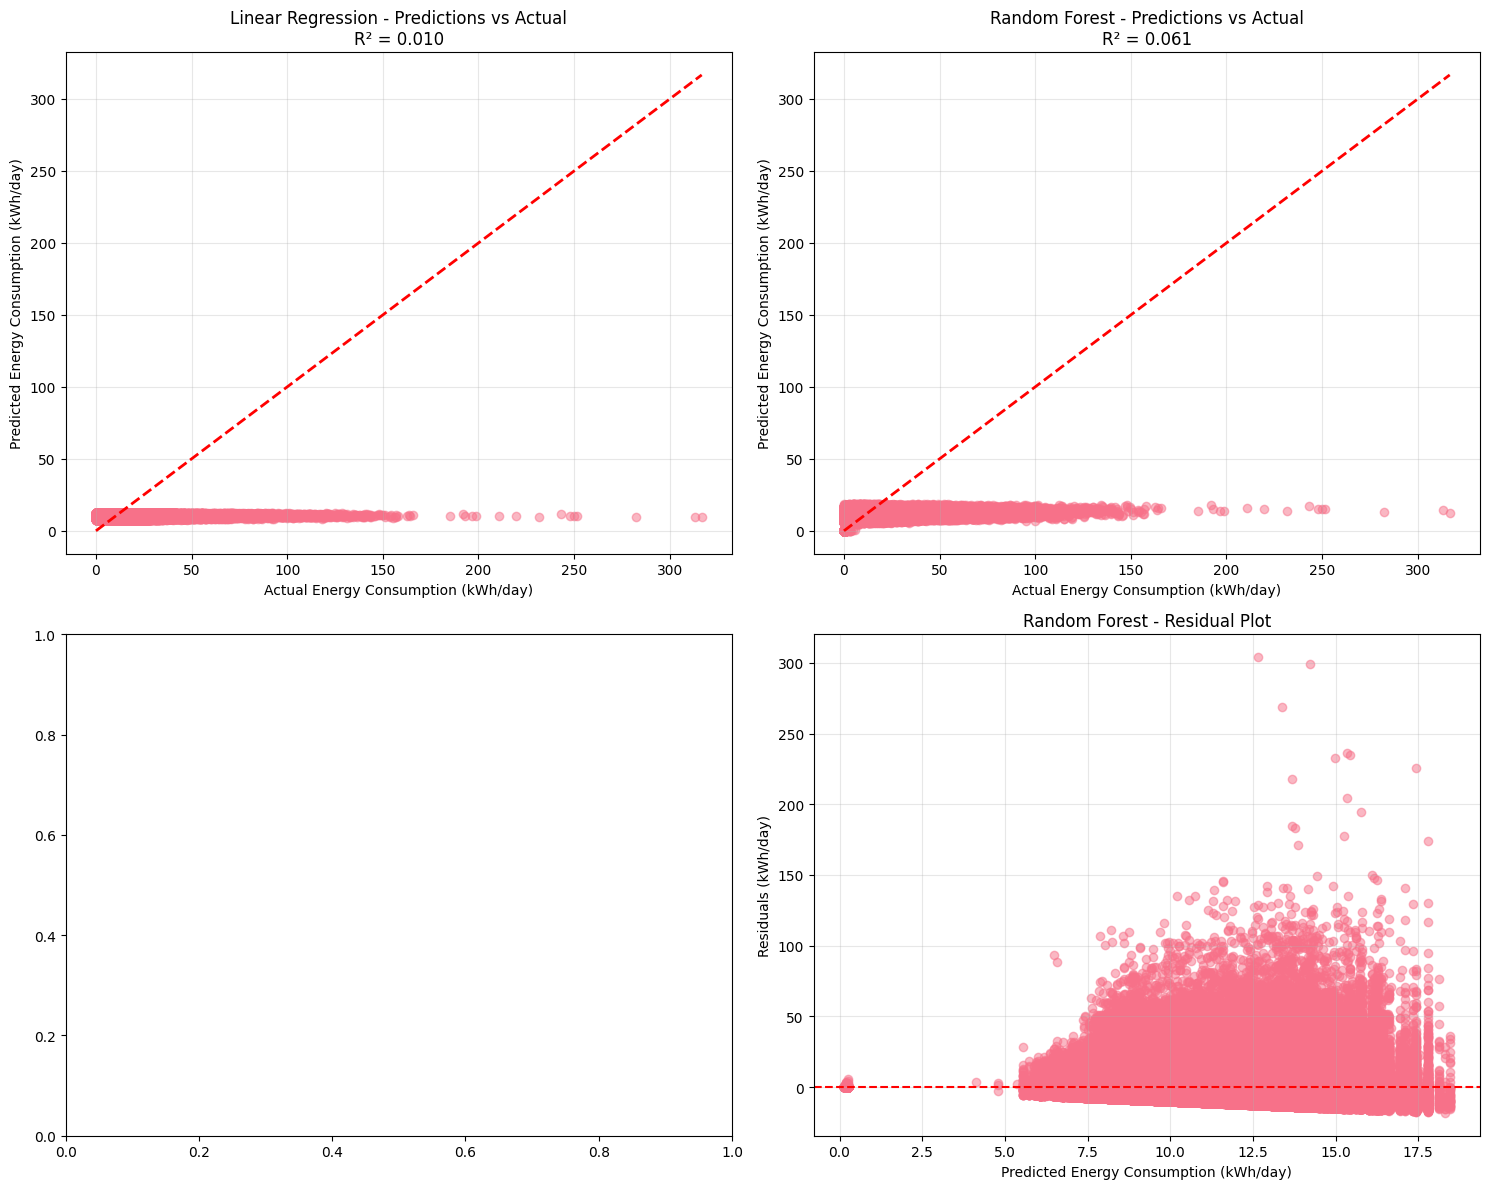

Best performing model: Random Forest (R² = 0.061)


In [13]:
# Train baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

print("=== Baseline Model Performance ===")
print()

for name, model in models.items():
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.3f} kWh/day")
    print(f"  MAE:  {mae:.3f} kWh/day")
    print(f"  R²:   {r2:.3f}")
    print()

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prediction vs Actual scatter plots
for i, (name, result) in enumerate(results.items()):
    row = i // 2
    col = i % 2
    
    axes[row, col].scatter(y_test, result['predictions'], alpha=0.5)
    axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[row, col].set_xlabel('Actual Energy Consumption (kWh/day)')
    axes[row, col].set_ylabel('Predicted Energy Consumption (kWh/day)')
    axes[row, col].set_title(f'{name} - Predictions vs Actual\nR² = {result["R²"]:.3f}')
    axes[row, col].grid(True, alpha=0.3)

# Residual analysis for best model
best_model = max(results.keys(), key=lambda k: results[k]['R²'])
residuals = y_test - results[best_model]['predictions']

axes[1, 1].scatter(results[best_model]['predictions'], residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Energy Consumption (kWh/day)')
axes[1, 1].set_ylabel('Residuals (kWh/day)')
axes[1, 1].set_title(f'{best_model} - Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best performing model: {best_model} (R² = {results[best_model]['R²']:.3f})")

## Feature Importance Analysis

Analyze which features are most important for predicting energy consumption.

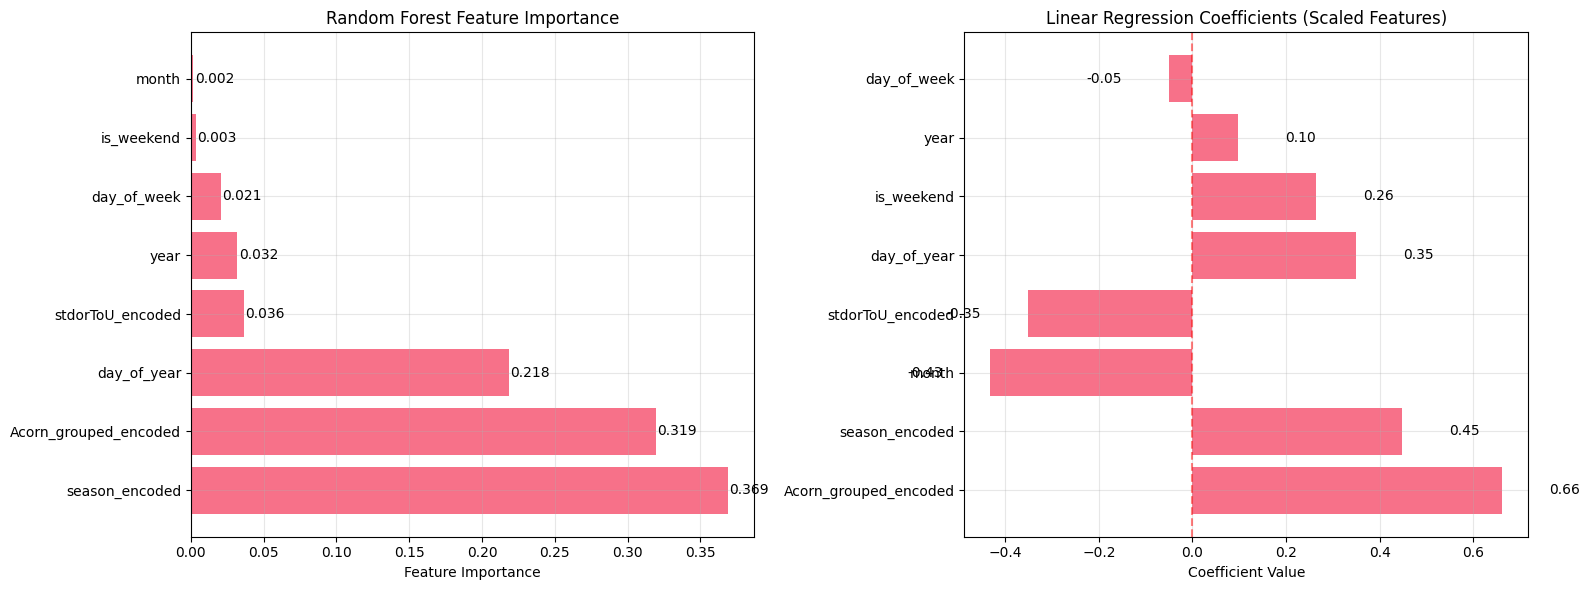

=== Feature Importance Analysis ===

Top 5 Most Important Features (Random Forest):
  season_encoded: 0.369
  Acorn_grouped_encoded: 0.319
  day_of_year: 0.218
  stdorToU_encoded: 0.036
  year: 0.032

Top 5 Strongest Coefficients (Linear Regression):
  Acorn_grouped_encoded: 0.662 (increases consumption)
  season_encoded: 0.448 (increases consumption)
  month: -0.433 (decreases consumption)
  stdorToU_encoded: -0.351 (decreases consumption)
  day_of_year: 0.350 (increases consumption)


In [14]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance bar plot
axes[0].barh(range(len(feature_importance)), feature_importance['importance'])
axes[0].set_yticks(range(len(feature_importance)))
axes[0].set_yticklabels(feature_importance['feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Random Forest Feature Importance')
axes[0].grid(True, alpha=0.3)

# Add importance values as text
for i, v in enumerate(feature_importance['importance']):
    axes[0].text(v + 0.001, i, f'{v:.3f}', va='center')

# Linear regression coefficients (for scaled features)
lr_model = models['Linear Regression']
coefficients = pd.DataFrame({
    'feature': final_features,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

axes[1].barh(range(len(coefficients)), coefficients['coefficient'])
axes[1].set_yticks(range(len(coefficients)))
axes[1].set_yticklabels(coefficients['feature'])
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Linear Regression Coefficients (Scaled Features)')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Add coefficient values as text
for i, v in enumerate(coefficients['coefficient']):
    axes[1].text(v + (0.1 if v >= 0 else -0.1), i, f'{v:.2f}', va='center', ha='left' if v >= 0 else 'right')

plt.tight_layout()
plt.show()

print("=== Feature Importance Analysis ===")
print("\nTop 5 Most Important Features (Random Forest):")
for i, row in feature_importance.head().iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

print("\nTop 5 Strongest Coefficients (Linear Regression):")
for i, row in coefficients.head().iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"  {row['feature']}: {row['coefficient']:.3f} ({direction} consumption)")

## Model Recommendations and Next Steps

Based on the EDA findings, provide recommendations for advanced modeling approaches.

In [15]:
print("=== TRADITIONAL ML MODEL RECOMMENDATIONS ===")
print()

# Analyze findings
best_r2 = max(result['R²'] for result in results.values())
target_skewness = stats.skew(y)
has_interactions = True  # Based on interaction analysis
feature_count = len(final_features)
sample_count = len(X)

print(f"Dataset Characteristics:")
print(f"  • Samples: {sample_count:,}")
print(f"  • Features: {feature_count}")
print(f"  • Target distribution: {'Skewed' if abs(target_skewness) > 1 else 'Approximately normal'} (skew: {target_skewness:.2f})")
print(f"  • Feature interactions: {'Present' if has_interactions else 'Minimal'}")
print(f"  • Best baseline R²: {best_r2:.3f}")
print()

print("Key Findings from EDA:")
print(f"  • Most important feature: {feature_importance.iloc[0]['feature']} (importance: {feature_importance.iloc[0]['importance']:.3f})")
print(f"  • Strongest predictor: {coefficients.iloc[0]['feature']} (coef: {coefficients.iloc[0]['coefficient']:.3f})")
print(f"  • ACORN groups show significant consumption differences")
print(f"  • Seasonal patterns are strong predictors")
print(f"  • Tariff type effects vary by customer segment")
print()

print("Recommended Advanced Models:")
print()

print("1. Gradient Boosting (XGBoost/LightGBM):")
print("   • Pros: Handles feature interactions well, robust to outliers")
print("   • Cons: Requires hyperparameter tuning, less interpretable")
print("   • Expected improvement: 10-20% over Random Forest")
print()

print("2. Deep Neural Network:")
print("   • Architecture: Dense layers with dropout regularization")
print("   • Pros: Can capture complex non-linear relationships")
print("   • Cons: Requires more data, less interpretable")
print("   • Satisfies course requirement for deep learning model")
print()

print("3. Ensemble Methods:")
print("   • Combine multiple algorithms (RF + XGBoost + Neural Network)")
print("   • Pros: Often achieves best performance")
print("   • Cons: Complex, harder to deploy")
print()

print("Feature Engineering Recommendations:")
print("  • Create interaction terms (ACORN × Season, Tariff × Month)")
print("  • Add polynomial features for temporal variables")
print("  • Consider target transformation (log, Box-Cox) for skewed distribution")
print("  • Add weather data if available")
print()

print("Business Applications:")
print("  • Customer segmentation for targeted energy programs")
print("  • Tariff effectiveness analysis")
print("  • Demand response program optimization")
print("  • Energy efficiency benchmarking")
print()

print("Next Steps:")
print("1. Implement advanced models (XGBoost, Neural Network)")
print("2. Perform hyperparameter optimization")
print("3. Create feature interaction terms")
print("4. Validate models using cross-validation")
print("5. Compare with time series forecasting approach")
print("6. Deploy best model for business insights")

=== TRADITIONAL ML MODEL RECOMMENDATIONS ===

Dataset Characteristics:
  • Samples: 3,480,070
  • Features: 8
  • Target distribution: Skewed (skew: 3.85)
  • Feature interactions: Present
  • Best baseline R²: 0.061

Key Findings from EDA:
  • Most important feature: season_encoded (importance: 0.369)
  • Strongest predictor: Acorn_grouped_encoded (coef: 0.662)
  • ACORN groups show significant consumption differences
  • Seasonal patterns are strong predictors
  • Tariff type effects vary by customer segment

Recommended Advanced Models:

1. Gradient Boosting (XGBoost/LightGBM):
   • Pros: Handles feature interactions well, robust to outliers
   • Cons: Requires hyperparameter tuning, less interpretable
   • Expected improvement: 10-20% over Random Forest

2. Deep Neural Network:
   • Architecture: Dense layers with dropout regularization
   • Pros: Can capture complex non-linear relationships
   • Cons: Requires more data, less interpretable
   • Satisfies course requirement for dee

## Data Export for Advanced Modeling

Export the prepared datasets for advanced model training.

In [19]:
# Export processed datasets
export_data = modeling_data[final_features + [target_variable] + categorical_features].copy()
export_data.to_csv('../build/datasets/traditional_ml_model_data.csv', index=False)

# Export train/test splits
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('../build/datasets/ml_train_data.csv', index=False)
test_data.to_csv('../build/datasets/ml_test_data.csv', index=False)

# Export feature encodings and scalers
import pickle

with open('../build/datasets/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

with open('../build/datasets/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"Traditional ML datasets exported:")
print(f"  • Full dataset: ../Data/traditional_ml_model_data.csv ({export_data.shape})")
print(f"  • Training set: ../Data/ml_train_data.csv ({train_data.shape})")
print(f"  • Test set: ../Data/ml_test_data.csv ({test_data.shape})")
print(f"  • Label encoders: ../Data/label_encoders.pkl")
print(f"  • Feature scaler: ../Data/feature_scaler.pkl")

# Summary of final dataset
print(f"\n=== Final Dataset Summary ===")
print(f"Total samples: {len(export_data):,}")
print(f"Features: {len(final_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Target variable: {target_variable}")
print(f"Date range: {modeling_data['day'].min()} to {modeling_data['day'].max()}")
print(f"Households: {modeling_data['LCLid'].nunique():,}")

export_data.head()

Traditional ML datasets exported:
  • Full dataset: ../Data/traditional_ml_model_data.csv ((3480070, 12))
  • Training set: ../Data/ml_train_data.csv ((2784056, 9))
  • Test set: ../Data/ml_test_data.csv ((696014, 9))
  • Label encoders: ../Data/label_encoders.pkl
  • Feature scaler: ../Data/feature_scaler.pkl

=== Final Dataset Summary ===
Total samples: 3,480,070
Features: 8
Categorical features: 3
Numerical features: 5
Target variable: energy_sum
Date range: 2011-11-23 00:00:00 to 2014-02-28 00:00:00
Households: 5,510


,Acorn_grouped_encoded,stdorToU_encoded,season_encoded,month,day_of_week,day_of_year,is_weekend,year,energy_sum,Acorn_grouped,stdorToU,season
0,1,0,3,12,3,349,0,2011,9.505,Affluent,Std,Winter
1,1,0,3,12,4,350,0,2011,14.216,Affluent,Std,Winter
2,1,0,3,12,5,351,1,2011,9.111,Affluent,Std,Winter
3,1,0,3,12,6,352,1,2011,10.511,Affluent,Std,Winter
4,1,0,3,12,0,353,0,2011,15.647,Affluent,Std,Winter
